# Optimisation: Maximising a loglikelihood

As well as minimising error functions, PINTS optimisation can be used to find the maximum of a loglikelihood (or of any [pints.LogPDF object](https://pints.readthedocs.io/en/latest/log_pdfs.html#pints.LogPDF)).

Following on from the [first example](optimisation-first-example.ipynb), we can define an inference problem using the [logistic model](https://pints.readthedocs.io/en/latest/toy/logistic_model.html#module-pints.toy):

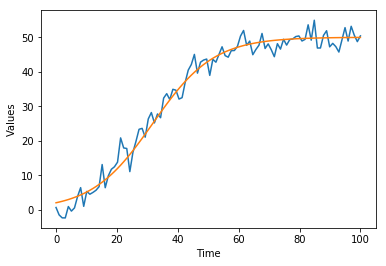

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy as toy

# Create a model
model = toy.LogisticModel()

# Set some parameters
real_parameters = [0.1, 50]

# Create fake data
times = model.suggested_times()
values = model.simulate(real_parameters, times)
noisy_values = values + np.random.normal(0, 3, times.shape)

# Create an inference problem
problem = pints.SingleOutputProblem(model, times, noisy_values)

# Show the generated data
plt.figure()
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, noisy_values)
plt.plot(times, values)
plt.show()

As before, we can now define an error function an minimise it:

In [4]:
score = pints.SumOfSquaresError(problem)

boundaries = pints.RectangularBoundaries([0, 5], [1, 500])

x0 = np.array([0.5, 200])
opt = pints.Optimisation(score, x0, method=pints.XNES)
opt.set_log_to_screen(False)
x1, f1 = opt.run()
print('Obtained parameters:')
print(x1)

Obtained parameters:
[ 0.10335618 49.37330126]


But we could also use a log likelihood instead!

In [5]:
loglikelihood = pints.UnknownNoiseLogLikelihood(problem)

In [6]:
opt = pints.Optimisation(loglikelihood, x0, method=pints.XNES)
x2, f2 = opt.run()

ValueError: Starting point must have same dimension as function to optimise.

Uh oh! What's happened here?

The likelihood function we used requires a `sigma` parameter, an extra parameter it adds to the inference problem that describes the estimated noise level in the data.

This means the number of parameters in our loglikelihood has gone up by one from the problem's number of parameters:

In [7]:
print(model.n_parameters())

2


In [8]:
print(problem.n_parameters())

2


In [9]:
print(loglikelihood.n_parameters())

3


As a result, we need to update our initial point (and boundaries) with a guess for what sigma may be.

In a realistic situtation, we could try to find a flat bit of signal to obtain a first estimate. In this example, we'll just start off by guessing `sigma=1`:

In [10]:
y0 = np.array([0.5, 200, 1])

boundaries_3d = pints.RectangularBoundaries([0, 5, 1e-3], [1, 500, 10])

opt = pints.Optimisation(loglikelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Obtained parameters:')
print(y1)

Obtained parameters:
[ 0.10335618 49.37330124  2.49241795]


Note that the noise has introduced a slight bias into the outcome, and the estimated sigma is slightly smaller than the true value of 3!

As before, we can now plot a simulation with the obtained parameters, and see how it matches the data:

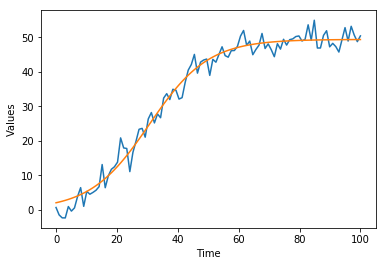

In [11]:
# Show the generated data
plt.figure()
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, noisy_values)
plt.plot(times, problem.evaluate(y1[:2]))
plt.show()